In [1]:
# Installing the nilearn package
!pip install nilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 62.2 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [2]:
# Mounting the google drive to the notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# This line allows plotting directly in the notebook
%matplotlib inline

# Importing the important packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import gc

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve

from nilearn import image, plotting
from nilearn.image import mean_img
from nilearn.datasets import fetch_abide_pcp

from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical

In [ ]:
# Checking the versions of the packages
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
array-record                  0.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         23.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
build                         0.10.0
CacheControl                  0.12.11
cac

In [ ]:
# Checking the GPU Google Colab uses
!nvidia-smi

Tue May  2 11:00:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    31W /  70W |    373MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# The abide datset is imported here. We specify where we want the data to be loaded 
# and which preprocessing pipeline to use,which derivatives to download, and
# the number of subjects we want to download.
abide = fetch_abide_pcp(data_dir = r'/content/drive/MyDrive/MasterThesis/Data',
                        pipeline = 'cpac',
                        derivatives=['func_preproc','reho'],
                        
                        band_pass_filtering = True,
                        global_signal_regression = True,
                        verbose = 1,
                        n_subjects = 500
                        )
                    
                                         
# We look at the available data in this dataset
print(abide.keys())

/usr/local/lib/python3.10/dist-packages/nilearn/datasets/func.py:1192: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


dict_keys(['description', 'phenotypic', 'func_preproc', 'reho'])


In [6]:
# Assigning the fMRI scans, reho images and phenotypical data to variables
func = abide.func_preproc
pheno = abide.phenotypic
reho = abide.reho

# Checking how many instances we have
print(len(func))

500


In [7]:
# Turning the phenotypical data into a pandas DataFrame
pheno_pd = pd.DataFrame(pheno)

In [8]:
# Transforming the labels of the DX_GROUP for ease of analysis where
# 0 = TD and 1 = ASD
adj_dx = pheno_pd['DX_GROUP'].replace([1, 2], [1, 0])
pheno_pd['DX_GROUP'] = adj_dx

In [9]:
# Looking how many instances we have of each group
pheno_pd['DX_GROUP'].value_counts()

0    258
1    242
Name: DX_GROUP, dtype: int64

In [10]:
# Checking the number of subjects per data collection site
pheno_pd['SITE_ID'].value_counts()

UM_1        86
USM         67
PITT        50
YALE        41
UM_2        34
TRINITY     33
KKI         33
OLIN        28
LEUVEN_1    28
LEUVEN_2    28
SDSU        27
OHSU        25
CMU         11
NYU          9
Name: SITE_ID, dtype: int64

In [11]:
# Checking out the phenotypical data
pheno_pd.head()

,i,Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
1,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
3,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1
4,5,6,50007,6,50007,PITT,Pitt_0050007,1,1,17.78,...,NaN,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1


In [12]:
# Creating a vector of the labels
labels = pheno_pd['DX_GROUP'].values

# **Visualization**


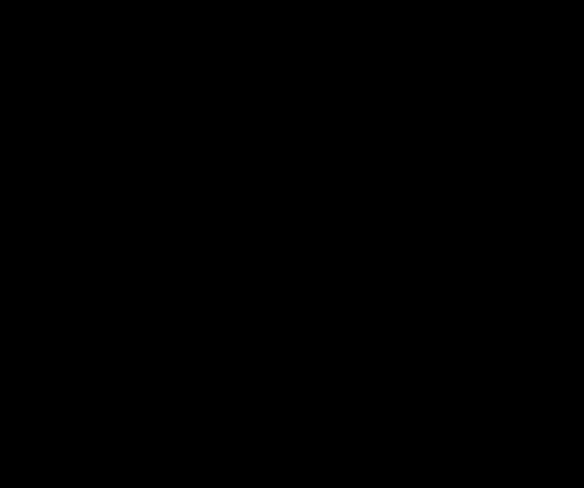
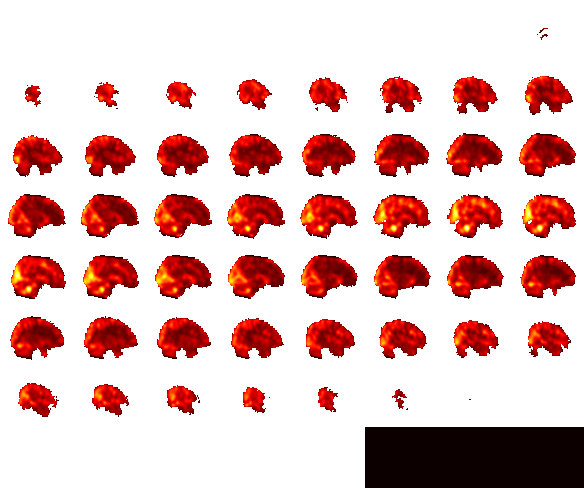

In [ ]:
# Plotting an interactive reho image of the first subject
# Slices of the images can be changed by clicking on either of the three images
img = reho[0]
plotting.view_img(img, draw_cross = False, bg_img = False, colorbar = False, black_bg = True, annotate = True, title = 'Reho Image' )

In [ ]:
# Creating the mean_img of the functional fMRI images
img2 = image.load_img(func[0])
mean_image = mean_img(img2)


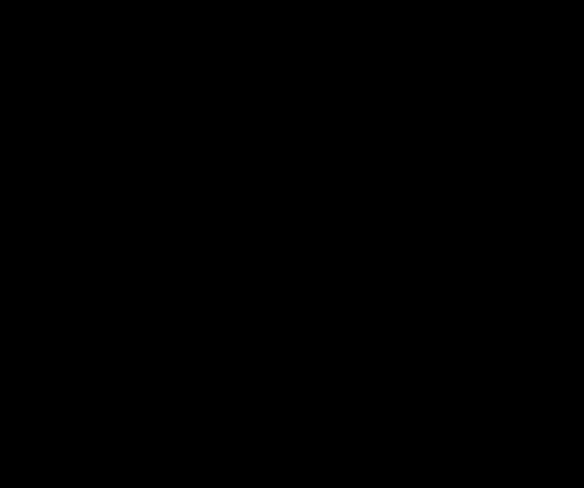
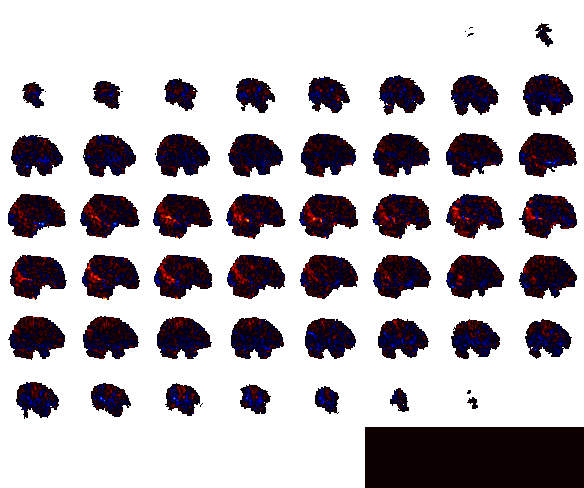

In [ ]:
# Plotting the interactive mean fMRI image
# Slices of the brain can be changed by clicking on either of the three images.
plotting.view_img(mean_image, draw_cross = False, bg_img = False, colorbar = False, black_bg = True, annotate = True, title = 'Mean Image')

# **Support Vector Machine - ReHo Full**

In [ ]:
# Flatten the ReHo images to create a feature vector for each subject
X = []
for f in reho:

  # Load_img loads the file as an image and get_fdata gets the numeric values
  # ravel flattens the (61, 73, 61) array retrieved by get_fdata

  X.append(image.load_img(f).get_fdata().ravel())
  print("done with", f)

# Checking if all the subjects got passed

X_array = np.array(X)
X_array.shape
'''

done with /content/drive/MyDrive/MasterThesis/Data/ABIDE_pcp/cpac/filt_global/Pitt_0050003_reho.nii.gz
done with /content/drive/MyDrive/MasterThesis/Data/ABIDE_pcp/cpac/filt_global/Pitt_0050004_reho.nii.gz
done with /content/drive/MyDrive/MasterThesis/Data/ABIDE_pcp/cpac/filt_global/Pitt_0050005_reho.nii.gz
done with /content/drive/MyDrive/MasterThesis/Data/ABIDE_pcp/cpac/filt_global/Pitt_0050006_reho.nii.gz
done with /content/drive/MyDrive/MasterThesis/Data/ABIDE_pcp/cpac/filt_global/Pitt_0050007_reho.nii.gz
done with /content/drive/MyDrive/MasterThesis/Data/ABIDE_pcp/cpac/filt_global/Pitt_0050008_reho.nii.gz
done with /content/drive/MyDrive/MasterThesis/Data/ABIDE_pcp/cpac/filt_global/Pitt_0050010_reho.nii.gz
done with /content/drive/MyDrive/MasterThesis/Data/ABIDE_pcp/cpac/filt_global/Pitt_0050011_reho.nii.gz
done with /content/drive/MyDrive/MasterThesis/Data/ABIDE_pcp/cpac/filt_global/Pitt_0050012_reho.nii.gz
done with /content/drive/MyDrive/MasterThesis/Data/ABIDE_pcp/cpac/filt_gl

(500, 271633)

In [ ]:
# Saving the feature array to a file
np.save('/content/drive/MyDrive/MasterThesis/Data/flat_reho_500.npy', X_array)

In [ ]:
# Freeing up some memory
del X, X_array
gc.collect()

163

In [13]:
# Loading in the flattened Reho data
svm_data = np.load('/content/drive/MyDrive/MasterThesis/Data/flat_reho_500.npy')

In [14]:
#Splitting data into a training and testing set
x_train, x_test, y_train, y_test = train_test_split(svm_data, labels, test_size = 0.1, random_state = 60)

In [15]:
# Checking the shapes of the training and testing set
print(np.array(x_train).shape)
print(np.array(y_train).shape)
print(np.array(x_test).shape)
print(np.array(y_test).shape)

(450, 271633)
(450,)
(50, 271633)
(50,)


In [16]:
# Deleting the svm_data array to clear up some memory
del svm_data
gc.collect()

11

In [18]:
# Executing the GridSearchCV to find the best parameters for our SVM model
param_grid = { 'C':[0.1, 1, 10],
              'kernel':['linear', 'rbf']}
clf = GridSearchCV(SVC(), param_grid, verbose = 4)

# Fitting the GridSearch to our training data
clf.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.578 total time=  41.2s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.633 total time=  40.5s
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.533 total time=  42.1s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.611 total time=  40.5s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.622 total time=  40.2s
[CV 1/5] END .................C=0.1, kernel=rbf;, score=0.533 total time=  50.5s
[CV 2/5] END .................C=0.1, kernel=rbf;, score=0.522 total time=  49.5s
[CV 3/5] END .................C=0.1, kernel=rbf;, score=0.522 total time=  49.2s
[CV 4/5] END .................C=0.1, kernel=rbf;, score=0.522 total time=  48.0s
[CV 5/5] END .................C=0.1, kernel=rbf;, score=0.522 total time=  49.6s
[CV 1/5] END ................C=1, kernel=linear;, score=0.578 total time=  40.6s
[CV 2/5] END ................C=1, kernel=linear;,

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
             verbose=4)

In [20]:
# Printing the best parameters
print(clf.best_params_)

# Printing the accuracy on the testing set using said best parameters
print(clf.score(x_test,y_test))

{'C': 10, 'kernel': 'rbf'}
0.64


In [21]:
# Let the model predict the classes of the testing set
y_pred = clf.predict(x_test)

In [22]:
# Calculate the accuracy of the SVM model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Reporting the precision, recall and accuracy for the SVM model
print(classification_report(y_test,y_pred))

Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.58      0.64      0.61        22
           1       0.69      0.64      0.67        28

    accuracy                           0.64        50
   macro avg       0.64      0.64      0.64        50
weighted avg       0.64      0.64      0.64        50



Text(0.5, 1.0, 'SVM - ReHo')

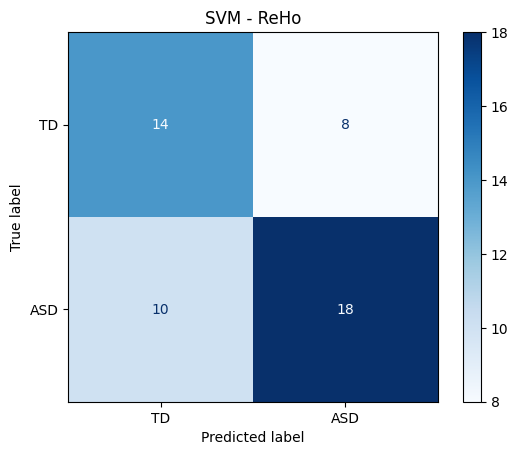

In [24]:
# Printing the confusion matrix
confusion = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels = ['TD', 'ASD'])

cmd.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
cmd.ax_.set_title("SVM - ReHo")

In [ ]:
# Calculating the mean sensitivity of the model
sensitivity_asd = confusion[1][1]/(confusion[1][1] + confusion[1][0])

print("Sensitivity ASD:", np.round(sensitivity_asd, decimals = 3))

# Calculating the mean specificity of the model
specificity_td = confusion[0][0]/(confusion[0][0] + confusion[0][1])

print("Specificity TD:", np.round(specificity_td, decimals = 3))

Sensitivity ASD: 0.643
Specificity TD: 0.636


# **3D Convolutional Neural Network - ReHo Full**

In [ ]:
# Processing of the scans and data loader is adapted from https://github.com/keras-team/keras-io/blob/master/examples/vision/3D_image_classification.py
# 3D CNN Architecture is adapted and adjusted from Liang et al. (2022)

# First two functions are created to read the nifti files and read them

def read_nifti_file(filepath):
    # read file
    scan = image.load_img(filepath)
    # get raw data
    scan = scan.get_fdata()
    return scan

def process_scan(path):
    # read scan
    volume = read_nifti_file(path)
    return volume

In [ ]:
# Calling the functions to read the scans and adding them to a numpy array
reho_scans = np.array([process_scan(path) for path in reho])
print('Done')

Done


In [ ]:
# Saving the numpy array so it can be used later
np.save('/content/drive/MyDrive/MasterThesis/Data/reho_scans_500.npy', reho_scans)

In [ ]:
# Transforming the binary labels to categorical labels
labels = to_categorical(labels, num_classes = 2)

In [ ]:
# Loading in the scans as 'reho_scans'
reho_scans = np.load('/content/drive/MyDrive/MasterThesis/Data/reho_scans_500.npy')

In [ ]:
# Checking if the data is loaded in and transformed correctly
print(reho_scans.shape)
print(labels.shape)

(500, 61, 73, 61)
(500, 2)


In [ ]:
# Defining two functions that will add an additional dimension to the training
# and validation Data. Adapted and adjusted from Zunair (2020)

def train_preprocessing(volume, labels):
    volume = tf.expand_dims(volume, axis=3)
    return volume, labels


def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [ ]:
# Creating the initial training and testing set with a 90-10 split
x_train, x_test, y_train, y_test = train_test_split(reho_scans, labels, test_size = 0.1, 
                                                    shuffle = True, random_state = 60)

In [ ]:
# The remaining 90% of the data will be used for the training and validation set
train_x, x_val, train_y, y_val = train_test_split(x_train, y_train, test_size = 0.2, 
                                                  shuffle = True, random_state = 60)

In [ ]:
# Adapted and adjusted from Zunair (2020)
# Define data loaders which create a dataset from the tensor slices of the inputs and target variables
train_loader = tf.data.Dataset.from_tensor_slices((train_x, train_y))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 6 
# Apply the functions from above to the data loaders to get the dataset
# We also define the batch size that the model will use here
train_dataset = (
    train_loader.shuffle(len(train_x), seed = 6, reshuffle_each_iteration = False)
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(6))

validation_dataset = (
    validation_loader.shuffle(len(x_val), seed = 6, reshuffle_each_iteration = False)
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(6))

In [ ]:
# The 3D CNN as described by Liang et al. (2022)

# We first define the input shape which are the three axes of the 3D image + the
# color channel
input_shape = (61, 73, 61, 1)  # the input has a single channel

# We then define the model architecture
model = Sequential()

# First layer of average pooling
model.add(layers.AveragePooling3D(pool_size=(2, 2, 2), 
                           strides=(2, 2, 2), 
                           input_shape=input_shape))
    
# Two convolutional layers with batch normalization
# We assume 'relu' activation
model.add(layers.Conv3D(filters=128, 
                        kernel_size=(3, 3, 3), 
                        padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
    
model.add(layers.Conv3D(filters=32, 
                        kernel_size=(3, 3, 3), 
                        padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
    
# Max-pooling layer
model.add(layers.MaxPooling3D(pool_size=(4, 4, 4), strides=(4, 4, 4))),
    
# Flatten the output
model.add(layers.Flatten())
    
# First fully connected layer with batch normalization
model.add(layers.Dense(units=200))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
    
# Second fully connected layer with batch normalization
model.add(layers.Dense(units=32))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
    
# Output layer with softmax activation for binary classification
# 2 units since we have two classes that can be classified
model.add(layers.Dense(units=2, activation='softmax'))

# Print the model summary
model.summary()

# We compile the model with binary cross-entropy loss and SGD optimizer with momentum
model.compile(loss='binary_crossentropy', 
              optimizer=SGD(learning_rate=0.00005, momentum=0.9),
              metrics = ['accuracy'])

# We define the early stopping criteria that the model will stop
# when the validation accuracy hasn't improved after 15 epochs
early_stopping_cb = EarlyStopping(monitor="val_accuracy", patience=15)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling3d (AverageP  (None, 30, 36, 30, 1)    0         
 ooling3D)                                                       
                                                                 
 conv3d (Conv3D)             (None, 30, 36, 30, 128)   3584      
                                                                 
 batch_normalization (BatchN  (None, 30, 36, 30, 128)  512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 36, 30, 128)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 36, 30, 32)    110624    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 36, 30, 32)   1

In [ ]:
# We delete some variables that are not needed anymore to clear up some RAM 
del train_loader, validation_loader
del x_train, y_train, x_val, y_val, train_x, train_y
gc.collect()

499

In [ ]:
# We train the model, validating it at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[early_stopping_cb]
)

Epoch 1/50
60/60 - 17s - loss: 0.7877 - accuracy: 0.4972 - val_loss: 0.7022 - val_accuracy: 0.5222 - 17s/epoch - 288ms/step
Epoch 2/50
60/60 - 5s - loss: 0.6635 - accuracy: 0.6750 - val_loss: 0.7029 - val_accuracy: 0.5222 - 5s/epoch - 82ms/step
Epoch 3/50
60/60 - 5s - loss: 0.5813 - accuracy: 0.7889 - val_loss: 0.7063 - val_accuracy: 0.4667 - 5s/epoch - 85ms/step
Epoch 4/50
60/60 - 5s - loss: 0.5305 - accuracy: 0.8361 - val_loss: 0.7130 - val_accuracy: 0.4778 - 5s/epoch - 88ms/step
Epoch 5/50
60/60 - 5s - loss: 0.4910 - accuracy: 0.8944 - val_loss: 0.7124 - val_accuracy: 0.4778 - 5s/epoch - 87ms/step
Epoch 6/50
60/60 - 5s - loss: 0.4587 - accuracy: 0.9167 - val_loss: 0.7067 - val_accuracy: 0.4778 - 5s/epoch - 81ms/step
Epoch 7/50
60/60 - 5s - loss: 0.4355 - accuracy: 0.9306 - val_loss: 0.7046 - val_accuracy: 0.5000 - 5s/epoch - 84ms/step
Epoch 8/50
60/60 - 5s - loss: 0.4084 - accuracy: 0.9556 - val_loss: 0.7047 - val_accuracy: 0.5667 - 5s/epoch - 84ms/step
Epoch 9/50
60/60 - 5s - loss:

In [ ]:
# We add a dimension to x_test so it can be fed into the model
x_test = np.expand_dims(x_test, axis = 4)

# Predicting the test labels using the model
prediction = model.predict(x_test)

# Returning the index of label with the highest score
test_predicted_labels = np.argmax(prediction, axis = 1)
test_true_labels = np.argmax(y_test, axis = 1)

2/2 [==============================] - 3s 1s/step


              precision    recall  f1-score   support

           0       0.59      0.73      0.65        22
           1       0.74      0.61      0.67        28

    accuracy                           0.66        50
   macro avg       0.67      0.67      0.66        50
weighted avg       0.67      0.66      0.66        50

[[16  6]
 [11 17]]
2/2 [==============================] - 0s 98ms/step - loss: 0.7193 - accuracy: 0.6600


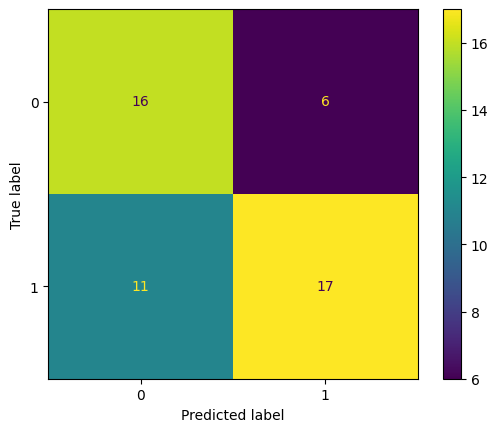

In [ ]:
# Calculating the precision, recall and accuracy of this run of the model
print(classification_report(test_true_labels,test_predicted_labels))

# Making the confusion matrix
cm = confusion_matrix(test_true_labels, test_predicted_labels)
print(cm)

# Plotting the confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')

results = model.evaluate(x_test, y_test)

In [ ]:
# We want to append the scores of 5 sequential runs
# Make the initial test and confusion matrix list
'''
test_list = []
cm_list = []
'''

In [ ]:
# Add the test accuracy and confusion matrix of the run to the lists
'''
test_list.append(results[1])
cm_list.append(cm)
'''

In [ ]:
# Make an array out of the list to easily save them
'''
test_acc_array1 = np.array(test_list)
test_cm_array1 = np.array(cm_list)
'''

In [ ]:
# Saving the first arrays
'''
np.save('/content/drive/MyDrive/MasterThesis/Data/test_acc_array_reho.npy', test_acc_array1)
np.save('/content/drive/MyDrive/MasterThesis/Data/test_cm_array_reho.npy', test_cm_array1)
'''

In [ ]:
# Loading in the array again after resetting the kernel
'''
test_acc_array = np.load('/content/drive/MyDrive/MasterThesis/Data/test_acc_array_reho.npy')
test_cm_array = np.load('/content/drive/MyDrive/MasterThesis/Data/test_cm_array_reho.npy')
'''

In [ ]:
# Appending the new results to the array
'''
test_acc_array = np.append(test_acc_array, results[1])
print(test_acc_array)
'''

[0.72000003 0.54000002 0.69999999 0.62       0.66000003]


In [ ]:
# Appending the new confusion matrix to the array
'''
test_cm_array = np.append(test_cm_array, cm)
print(test_cm_array)
'''

[16  6  8 20 14  8 15 13 15  7  8 20 16  6 13 15 16  6 11 17]


In [ ]:
# Saving the array
'''
np.save('/content/drive/MyDrive/MasterThesis/Data/test_acc_array_reho.npy', test_acc_array)
np.save('/content/drive/MyDrive/MasterThesis/Data/test_cm_array_reho.npy', test_cm_array)
'''

In [25]:
test_acc_array = np.load('/content/drive/MyDrive/MasterThesis/Data/test_acc_array_reho.npy')
test_cm_array = np.load('/content/drive/MyDrive/MasterThesis/Data/test_cm_array_reho.npy')

In [26]:
# Calculating the mean test accuracy
print(test_acc_array)
mean_test_acc = np.mean(test_acc_array)
print(mean_test_acc)

[0.72000003 0.54000002 0.69999999 0.62       0.66000003]
0.648000014


In [27]:
# Reshape the confusion matrix array to the correct shape
corr_cm_array = np.reshape(test_cm_array, (5,2,2))
print(corr_cm_array.shape)
print(corr_cm_array)

(5, 2, 2)
[[[16  6]
  [ 8 20]]

 [[14  8]
  [15 13]]

 [[15  7]
  [ 8 20]]

 [[16  6]
  [13 15]]

 [[16  6]
  [11 17]]]


In [28]:
# Calculating the mean of the confusion matrix
mean_cm = np.mean(corr_cm_array, axis = 0)
print(mean_cm)

[[15.4  6.6]
 [11.  17. ]]


Text(0.5, 1.0, '3D-CNN - ReHo')

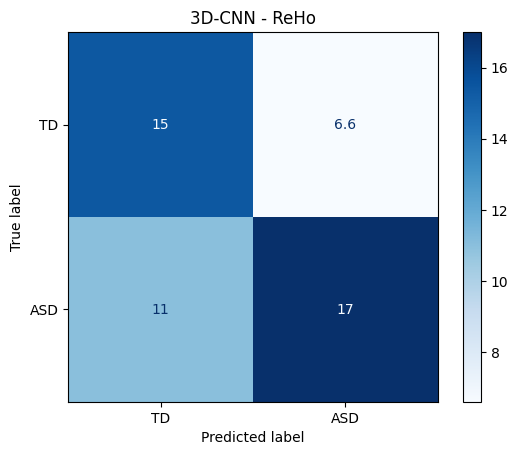

In [29]:
# Creating the confusion matrix display
confusion = mean_cm
cmd = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels = ['TD', 'ASD'])

cmd.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
cmd.ax_.set_title("3D-CNN - ReHo")

In [ ]:
# Calculating the mean sensitivity of the model
sensitivity_asd = mean_cm[1][1]/(mean_cm[1][1] + mean_cm[1][0])

print("Sensitivity ASD:", np.round(sensitivity_asd, decimals = 3))

# Calculating the mean specificity of the model
specificity_td = mean_cm[0][0]/(mean_cm[0][0] + mean_cm[0][1])

print("Specificity TD:", np.round(specificity_td, decimals = 3))

Sensitivity ASD: 0.607
Specificity TD: 0.7


# **Support Vector Machine - Mean fMRI Image**

In [ ]:
# Making a list of all the mean fMRI images
mean_imgs = []

for i in range(len(func)):
  # loads the image
  img = image.load_img(func[i])
  # creates the mean image
  mean_image = mean_img(img)
  # retrieves the numeric data
  mean_data = mean_image.get_fdata()
  # adds it to the mean image list
  mean_imgs.append(mean_data)
  print(i+1, "of", len(func), "done")

1 of 500 done
2 of 500 done
3 of 500 done
4 of 500 done
5 of 500 done
6 of 500 done
7 of 500 done
8 of 500 done
9 of 500 done
10 of 500 done
11 of 500 done
12 of 500 done
13 of 500 done
14 of 500 done
15 of 500 done
16 of 500 done
17 of 500 done
18 of 500 done
19 of 500 done
20 of 500 done
21 of 500 done
22 of 500 done
23 of 500 done
24 of 500 done
25 of 500 done
26 of 500 done
27 of 500 done
28 of 500 done
29 of 500 done
30 of 500 done
31 of 500 done
32 of 500 done
33 of 500 done
34 of 500 done
35 of 500 done
36 of 500 done
37 of 500 done
38 of 500 done
39 of 500 done
40 of 500 done
41 of 500 done
42 of 500 done
43 of 500 done
44 of 500 done
45 of 500 done
46 of 500 done
47 of 500 done
48 of 500 done
49 of 500 done
50 of 500 done
51 of 500 done
52 of 500 done
53 of 500 done
54 of 500 done
55 of 500 done
56 of 500 done
57 of 500 done
58 of 500 done
59 of 500 done
60 of 500 done
61 of 500 done
62 of 500 done
63 of 500 done
64 of 500 done
65 of 500 done
66 of 500 done
67 of 500 done
68 o

In [ ]:
# Creating an array of the mean image list to easily save it
mean_img_500_array = np.array(mean_imgs)

In [ ]:
# Saving the mean_img array
np.save('/content/drive/MyDrive/MasterThesis/Data/mean_imgs_500.npy', mean_img_500_array)

In [ ]:
# Loading it in to use it again
mean_img_500 = np.load('/content/drive/MyDrive/MasterThesis/Data/mean_imgs_500.npy') 

In [ ]:
# Checking if it shape is correct
mean_img_500.shape

(500, 61, 73, 61)

In [ ]:
# Flattening the mean_images for the SVM
x_fmri = []
j = 0

for i in mean_img_500:
  x_fmri.append(i.ravel())
  j += 1
  print("done with", j, "of", len(mean_img_500))

done with 1 of 500
done with 2 of 500
done with 3 of 500
done with 4 of 500
done with 5 of 500
done with 6 of 500
done with 7 of 500
done with 8 of 500
done with 9 of 500
done with 10 of 500
done with 11 of 500
done with 12 of 500
done with 13 of 500
done with 14 of 500
done with 15 of 500
done with 16 of 500
done with 17 of 500
done with 18 of 500
done with 19 of 500
done with 20 of 500
done with 21 of 500
done with 22 of 500
done with 23 of 500
done with 24 of 500
done with 25 of 500
done with 26 of 500
done with 27 of 500
done with 28 of 500
done with 29 of 500
done with 30 of 500
done with 31 of 500
done with 32 of 500
done with 33 of 500
done with 34 of 500
done with 35 of 500
done with 36 of 500
done with 37 of 500
done with 38 of 500
done with 39 of 500
done with 40 of 500
done with 41 of 500
done with 42 of 500
done with 43 of 500
done with 44 of 500
done with 45 of 500
done with 46 of 500
done with 47 of 500
done with 48 of 500
done with 49 of 500
done with 50 of 500
done with

In [ ]:
# Transforming it to an array to easiliy save it and to check out the shape
X_array = np.array(x_fmri)
X_array.shape

(500, 271633)

In [ ]:
# Saving the flattened mean images to a file
np.save('/content/drive/MyDrive/MasterThesis/Data/flat_fmri_500.npy', X_array)

In [ ]:
# Loading it in to use it again
fmri_data = np.load('/content/drive/MyDrive/MasterThesis/Data/flat_fmri_500.npy')

In [ ]:
#Splitting the data into a training and testing set
x_train, x_test, y_train, y_test = train_test_split(x_fmri, labels, test_size = 0.1, random_state = 60)

In [ ]:
# Checking out the shape of the data
print(np.array(x_train).shape)
print(np.array(y_train).shape)
print(np.array(x_test).shape)
print(np.array(y_test).shape)

(450, 271633)
(450,)
(50, 271633)
(50,)


In [ ]:
# Clearing up memory by deleting data we do not need anymore
del svm_data
gc.collect()

114

In [ ]:
# Finding the best parameters for the mean_img SVM
param_grid = { 'C':[0.1, 1, 10],
              'kernel':['linear', 'rbf']}
clf = GridSearchCV(SVC(), param_grid, verbose = 4)

# Fitting the Gridsearch to the training data
clf.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.522 total time=  45.6s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.411 total time=  45.2s
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.456 total time=  45.3s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.433 total time=  46.1s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.589 total time=  44.7s
[CV 1/5] END .................C=0.1, kernel=rbf;, score=0.533 total time=  56.0s
[CV 2/5] END .................C=0.1, kernel=rbf;, score=0.522 total time=  57.2s
[CV 3/5] END .................C=0.1, kernel=rbf;, score=0.522 total time=  54.9s
[CV 4/5] END .................C=0.1, kernel=rbf;, score=0.522 total time=  56.2s
[CV 5/5] END .................C=0.1, kernel=rbf;, score=0.522 total time=  56.7s
[CV 1/5] END ................C=1, kernel=linear;, score=0.522 total time=  45.7s
[CV 2/5] END ................C=1, kernel=linear;,

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
             verbose=4)

In [ ]:
# Printing the best parameters
print(clf.best_params_)

# Printing the accuracy score on the test set
print(clf.score(x_test,y_test))

{'C': 1, 'kernel': 'rbf'}
0.44


In [ ]:
# Letting the model predict the labels of the test set
y_pred = clf.predict(x_test)

In [ ]:
# Calculating the accuracy of the SVM model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculating the precision, recall and accuracy of the SVM model
print(classification_report(y_test,y_pred))

Accuracy: 0.44
              precision    recall  f1-score   support

           0       0.42      0.77      0.55        22
           1       0.50      0.18      0.26        28

    accuracy                           0.44        50
   macro avg       0.46      0.48      0.41        50
weighted avg       0.47      0.44      0.39        50



Text(0.5, 1.0, 'SVM - Mean Image')

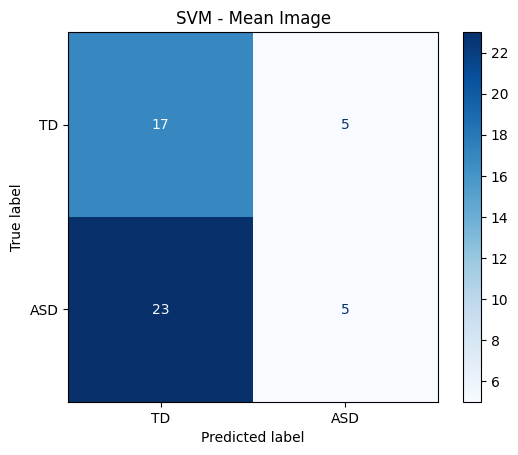

In [35]:
# Printing the confusion matrix
confusion = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels = ['TD', 'ASD'])

cmd.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
cmd.ax_.set_title("SVM - Mean Image")

In [ ]:
# Calculating the mean sensitivity of the model
sensitivity_asd = confusion[1][1]/(confusion[1][1] + confusion[1][0])

print("Sensitivity ASD:", np.round(sensitivity_asd, decimals = 3))

# Calculating the mean specificity of the model
specificity_td = confusion[0][0]/(confusion[0][0] + confusion[0][1])

print("Specificity TD:", np.round(specificity_td, decimals = 3))

Sensitivity ASD: 0.179
Specificity TD: 0.773


# **3D Convolutional Neural Network - Mean fMRI image** 

In [ ]:
# Loading in the Mean images previously created
mean_img_500 = np.load('/content/drive/MyDrive/MasterThesis/Data/mean_imgs_500.npy') 

In [ ]:
# Transforming the labels to categorical
labels = to_categorical(labels, num_classes = 2)

In [ ]:
# Checking out the shape of the data
print(mean_img_500.shape)
print(labels.shape)

(500, 61, 73, 61)
(500, 2)


In [ ]:
# Processing of the scans is adapted from https://github.com/keras-team/keras-io/blob/master/examples/vision/3D_image_classification.py
# 3D CNN Architecture is adapted and adjusted from Liang et al. (2022)

# First two functions are created to read the nifti files and read them

def train_preprocessing(volume, label):
    """Process training data by  adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    #volume = tf.tile(volume, [1, 1, 1, 3])
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    #volume = tf.tile(volume, [1, 1, 1, 3])
    return volume, label

In [ ]:
# Creating the initial training and testing set with a 90-10 split
x_train, x_test, y_train, y_test = train_test_split(mean_img_500, labels, test_size = 0.1, shuffle = True, random_state = 60)

In [ ]:
# The remaining 90% of the data will be used for the training and validation set
train_x, x_val, train_y, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state = 60)

In [ ]:
# Define data loaders which create a dataset from the tensor slices of the inputs and target variables
train_loader = tf.data.Dataset.from_tensor_slices((train_x, train_y))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 6 
# Apply the functions from above to the data loaders to get the dataset
# We also define the batch size that the model will use here
train_dataset = (
    train_loader.shuffle(len(train_x), seed = 6, reshuffle_each_iteration = False)
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(6))

validation_dataset = (
    validation_loader.shuffle(len(x_val), seed = 6, reshuffle_each_iteration = False)
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(6))

In [ ]:
# Delete some variables to clear up RAM space
del mean_img_500
del x_train, train_x, x_val, y_train, train_y, y_val
gc.collect()

0

In [ ]:
# The 3D CNN as described by Liang et al. (2022)

# We first define the input shape which are the three axes of the 3D image + the
# color channel
input_shape = (61, 73, 61, 1)  # the input has a single channel

# We then define the model architecture
model = Sequential()

# First layer of average pooling
model.add(layers.AveragePooling3D(pool_size=(2, 2, 2), 
                           strides=(2, 2, 2), 
                           input_shape=input_shape))
    
# Two convolutional layers with batch normalization
# We assume 'relu' activation
model.add(layers.Conv3D(filters=128, 
                        kernel_size=(3, 3, 3), 
                        padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
    
model.add(layers.Conv3D(filters=32, 
                        kernel_size=(3, 3, 3), 
                        padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
    
# Max-pooling layer
model.add(layers.MaxPooling3D(pool_size=(4, 4, 4), strides=(4, 4, 4))),
    
# Flatten the output
model.add(layers.Flatten())
    
# First fully connected layer with batch normalization
model.add(layers.Dense(units=200))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
    
# Second fully connected layer with batch normalization
model.add(layers.Dense(units=32))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
    
# Output layer with softmax activation for binary classification
# 2 units since we have two classes that can be classified
model.add(layers.Dense(units=2, activation='softmax'))

# Print the model summary
model.summary()

# We compile the model with binary cross-entropy loss and SGD optimizer with momentum
model.compile(loss='binary_crossentropy', 
              optimizer=SGD(learning_rate=0.00005, momentum=0.9),
              metrics = ['accuracy'])

# We define the early stopping criteria that the model will stop
# when the validation accuracy hasn't improved after 15 epochs
early_stopping_cb = EarlyStopping(monitor="val_accuracy", patience=15)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling3d (AverageP  (None, 30, 36, 30, 1)    0         
 ooling3D)                                                       
                                                                 
 conv3d (Conv3D)             (None, 30, 36, 30, 128)   3584      
                                                                 
 batch_normalization (BatchN  (None, 30, 36, 30, 128)  512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 36, 30, 128)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 36, 30, 32)    110624    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 36, 30, 32)   1

In [ ]:
# Delete some more variables to clear up RAM
del train_loader, validation_loader
gc.collect()

795

In [ ]:
# We train the model, validating it at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[early_stopping_cb]
)

Epoch 1/50
60/60 - 10s - loss: 0.7971 - accuracy: 0.4778 - val_loss: 0.6956 - val_accuracy: 0.4778 - 10s/epoch - 170ms/step
Epoch 2/50
60/60 - 5s - loss: 0.7326 - accuracy: 0.5528 - val_loss: 0.6898 - val_accuracy: 0.5333 - 5s/epoch - 75ms/step
Epoch 3/50
60/60 - 5s - loss: 0.7185 - accuracy: 0.5889 - val_loss: 0.6971 - val_accuracy: 0.5222 - 5s/epoch - 79ms/step
Epoch 4/50
60/60 - 5s - loss: 0.6718 - accuracy: 0.6694 - val_loss: 0.7128 - val_accuracy: 0.4444 - 5s/epoch - 76ms/step
Epoch 5/50
60/60 - 5s - loss: 0.6624 - accuracy: 0.6917 - val_loss: 0.7114 - val_accuracy: 0.4556 - 5s/epoch - 79ms/step
Epoch 6/50
60/60 - 5s - loss: 0.6304 - accuracy: 0.7083 - val_loss: 0.7179 - val_accuracy: 0.4778 - 5s/epoch - 82ms/step
Epoch 7/50
60/60 - 5s - loss: 0.6173 - accuracy: 0.7500 - val_loss: 0.7096 - val_accuracy: 0.5111 - 5s/epoch - 77ms/step
Epoch 8/50
60/60 - 5s - loss: 0.6012 - accuracy: 0.7611 - val_loss: 0.7263 - val_accuracy: 0.5444 - 5s/epoch - 77ms/step
Epoch 9/50
60/60 - 5s - loss:

2/2 [==============================] - 3s 1s/step
[0 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1
 0 0 1 1 0 1 0 1 1 0 1 0 1]
[0 1 0 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0
 1 1 1 1 1 0 0 0 1 0 1 0 0]
              precision    recall  f1-score   support

           0       0.35      0.36      0.36        22
           1       0.48      0.46      0.47        28

    accuracy                           0.42        50
   macro avg       0.41      0.41      0.41        50
weighted avg       0.42      0.42      0.42        50



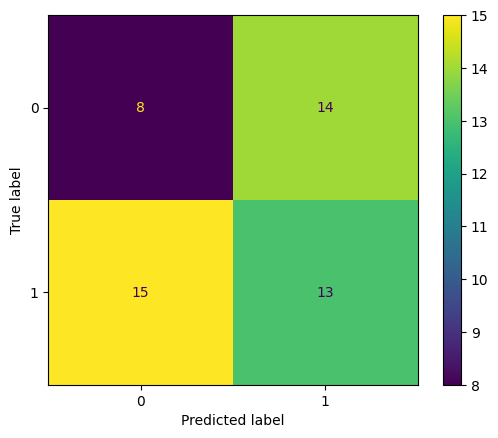

In [ ]:
# We add a dimension to x_test so it can be fed into the model
x_test = np.expand_dims(x_test, axis = 4)

# Predicting the test labels using the model
prediction = model.predict(x_test)

# Returning the index of label with the highest score
test_predicted_labels = np.argmax(prediction, axis = 1)
print(test_predicted_labels)
test_true_labels = np.argmax(y_test, axis = 1)
print(test_true_labels)

# Calculating the precision, recall and accuracy of the model
print(classification_report(test_true_labels,test_predicted_labels))

# Making the confusion matrix
cm = confusion_matrix(test_true_labels, test_predicted_labels)

# Plotting the confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')

In [ ]:
# Save the results of the model
results_fmri = model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 71ms/step - loss: 0.7709 - accuracy: 0.4200


In [ ]:
# Make the initial test and confusion matrix list
'''
test_list = []
cm_list = []
'''

In [ ]:
# Add the test accuracy and confusion matrix to the lists
'''
test_list.append(results_fmri[1])
cm_list.append(cm)
'''

In [ ]:
# Make an array out of the list to easily save them
'''
test_acc_array = np.array(test_list)
test_cm_array = np.array(cm_list)

print(test_acc_array)
print(test_cm_array)
'''

[0.5]
[[[20  2]
  [23  5]]]


In [ ]:
# Saving the first arrays
'''
np.save('/content/drive/MyDrive/MasterThesis/Data/test_acc_array.npy', test_acc_array)
np.save('/content/drive/MyDrive/MasterThesis/Data/test_cm_array.npy', test_cm_array)
'''

In [ ]:
# Loading in the array again after resetting the kernel
test_acc_array = np.load('/content/drive/MyDrive/MasterThesis/Data/test_acc_array.npy')
test_cm_array = np.load('/content/drive/MyDrive/MasterThesis/Data/test_cm_array.npy')

In [ ]:
# Appending the new results to the array
test_acc_array = np.append(test_acc_array, results_fmri[1])

In [ ]:
print(test_acc_array)

[0.5        0.5        0.46000001 0.5        0.41999999]


In [ ]:
print(test_acc_array)

[0.5        0.5        0.46000001 0.5        0.41999999]


In [ ]:
# Appending the new confusion matrix to the array
test_cm_array = np.append(test_cm_array, cm)

In [ ]:
print(test_cm_array)

[20  2 23  5 19  3 22  6 17  5 22  6 10 12 13 15  8 14 15 13]


In [ ]:
# Saving the array
np.save('/content/drive/MyDrive/MasterThesis/Data/test_acc_array_fmri.npy', test_acc_array)
np.save('/content/drive/MyDrive/MasterThesis/Data/test_cm_array_fmri.npy', test_cm_array)

In [36]:
test_acc_array = np.load('/content/drive/MyDrive/MasterThesis/Data/test_acc_array_fmri.npy')
test_cm_array = np.load('/content/drive/MyDrive/MasterThesis/Data/test_cm_array_fmri.npy')

In [37]:
# Calculating the mean test accuracy
print(test_acc_array)
mean_test_acc = np.mean(test_acc_array)
print(mean_test_acc)

[0.5        0.5        0.46000001 0.5        0.41999999]
0.4759999990463257


In [38]:
# Reshape the confusion matrix array to the correct shape
corr_cm_array = np.reshape(test_cm_array, (5,2,2))
print(corr_cm_array.shape)
print(corr_cm_array)

(5, 2, 2)
[[[20  2]
  [23  5]]

 [[19  3]
  [22  6]]

 [[17  5]
  [22  6]]

 [[10 12]
  [13 15]]

 [[ 8 14]
  [15 13]]]


In [39]:
# Calculating the mean of the confusion matrix
mean_cm = np.mean(corr_cm_array, axis = 0)
print(mean_cm)

[[14.8  7.2]
 [19.   9. ]]


Text(0.5, 1.0, '3D-CNN - Mean Image')

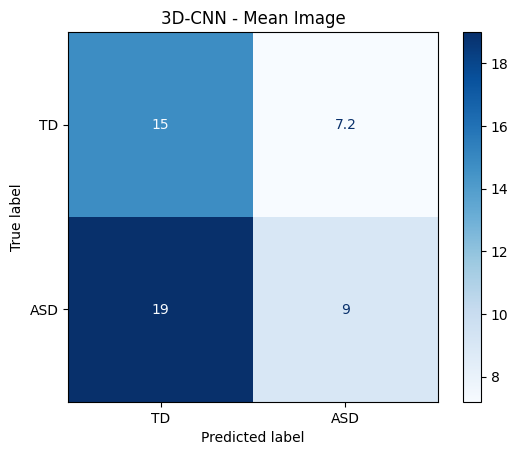

In [40]:
# Creating the confusion matrix display
confusion = mean_cm
cmd = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels = ['TD', 'ASD'])

cmd.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
cmd.ax_.set_title("3D-CNN - Mean Image")

In [ ]:
# Calculating the mean sensitivity of the model
sensitivity_asd = mean_cm[1][1]/(mean_cm[1][1] + mean_cm[1][0])

print("Sensitivity ASD:", np.round(sensitivity_asd, decimals = 3))

# Calculating the mean specificity of the model
specificity_td = mean_cm[0][0]/(mean_cm[0][0] + mean_cm[0][1])

print("Specificity TD:", np.round(specificity_td, decimals = 3))

Sensitivity ASD: 0.321
Specificity TD: 0.673
